#### Thanks to:
- Amira Adel Foda (intake 42 - smart village branch - group 2)
- Asmaa Said (intake 42 - smart village branch - group 2)
- Marawan Mohamed (intake 42 - Alex. branch - group 2)


### Installing MediaPipe

In [1]:
%%capture
!pip install mediapipe

### Required Libraries

In [33]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor

### Dowlining Data

In [3]:
# link of the data
# http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip
!wget "http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip"

--2023-02-23 16:13:23--  http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip
Resolving www.cbsr.ia.ac.cn (www.cbsr.ia.ac.cn)... 159.226.21.60
Connecting to www.cbsr.ia.ac.cn (www.cbsr.ia.ac.cn)|159.226.21.60|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87413900 (83M) [application/x-zip-compressed]
Saving to: ‘AFLW2000-3D.zip’

AFLW2000-3D.zip     100%[===================>]  83.36M  1.23MB/s    in 68s     

2023-02-23 16:14:31 (1.23 MB/s) - ‘AFLW2000-3D.zip’ saved [87413900/87413900]



In [4]:
# Loading AFLW2000 Data
%%capture
if os.path.isfile('/content/AFLW2000-3D.zip') == True:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip

### Assissting Functions


In [72]:
def face_points_image(image):
  out = []
  faceModule = mediapipe.solutions.face_mesh
  with faceModule.FaceMesh(static_image_mode=True) as faces:
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
      for face in results.multi_face_landmarks:
        x_,y_ = [],[]
        for landmark in face.landmark:
            x_.append(landmark.x)
            y_.append(landmark.y)
        _ = np.array(x_)
        __ = np.array(y_)
        features = np.hstack((_,__))
        out.append(features.reshape(1,-1))
      return out
    else:return np.array([[-1]])

In [73]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

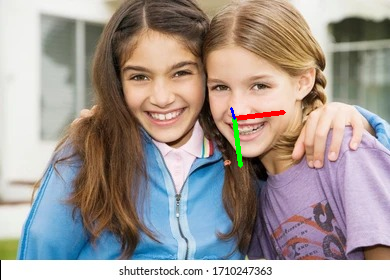

In [74]:
def predict_image(image):
  faces = face_points_image(image)
  #print(len(faces))
  shape = image.shape
  if faces[0].shape != np.array([-1]).shape:
    for face in faces:
      yaw = yaw_model.predict(face)
      pitch = pitch_model.predict(face)
      roll = roll_model.predict(face)
      distance = np.linalg.norm(np.array((face[:,10]*shape[1]/2,face[:,478]*shape[0]/2)) - np.array((face[:,152]*shape[1]/2,face[:,468+152]*shape[0]/2)),axis = 0).reshape(-1,1)
      image = draw_axis(image,pitch[0],yaw[0],roll[0],face[:,19]*shape[1],face[:,468+19]*shape[0],distance)
    return image
  else:return image
image = cv2.imread("/content/WhatsApp Image 2023-02-23 at 8.53.56 PM.jpeg")
cv2_imshow(predict_image(image))

### Preparing Data

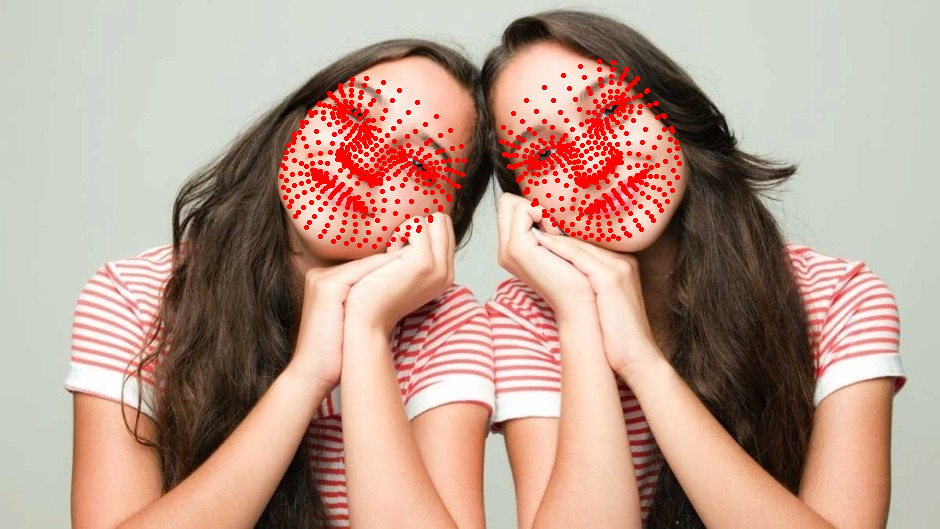

In [62]:
# choosing random image
random_file = 'image00013'

faceModule = mediapipe.solutions.face_mesh
# loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True,max_num_faces=3) as faces:
    # loading the image
    image = cv2.imread('/content/WhatsApp Image 2023-02-23 at 3.07.38 PM.jpeg')
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
      # looping over the faces in the image
      for face in results.multi_face_landmarks:
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = image.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
              cv2.circle(image, (relative_x, relative_y), radius=1, color=(0,0, 255), thickness=2)
      cv2_imshow(image)

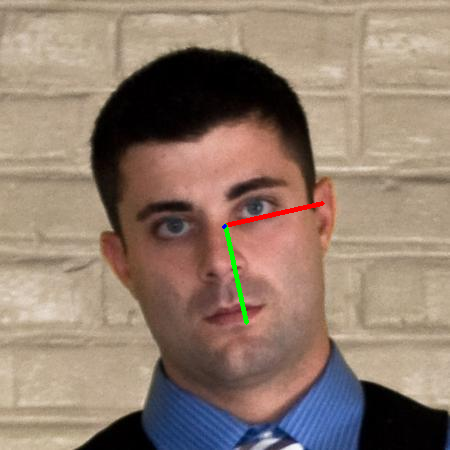

In [ ]:
image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat('/content/AFLW2000/'+random_file+'.mat')
# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
cv2_imshow(draw_axis(image,pitch,yaw,roll))

In [8]:
# choosing random image
X = []
Y = []
labels = []
for file in os.listdir("/content/AFLW2000/"):
  if file.endswith('.jpg'):
    faceModule = mediapipe.solutions.face_mesh
    # loading image and its correspinding mat file
    with faceModule.FaceMesh(static_image_mode=True) as faces:
        # loading the image
        image = cv2.imread('/content/AFLW2000/'+ file)
        # processing the face to extract the landmark points (468 point) for each x,y,z
        results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks != None: 
          # looping over the faces in the image
          mat_file = sio.loadmat('/content/AFLW2000/'+file[:-4] +'.mat')
          pose_para = mat_file["Pose_Para"][0][:3]
          x_,y_ = [],[]
          for face in results.multi_face_landmarks:
              for landmark in face.landmark:
                  x = landmark.x
                  y = landmark.y
                  # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                  shape = image.shape 
                  #relative_x = int(x * shape[1])
                  #relative_y = int(y * shape[0])
                  x_.append(x)
                  y_.append(y)
              labels.append(pose_para)
              X.append(x_)
              Y.append(y_)  
                  # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
X = np.array(X)
Y = np.array(Y)
labels = np.array(labels)
features = np.hstack((X,Y))

In [9]:
np.savetxt('features.csv',features,delimiter=',')
np.savetxt('labels.csv',features,delimiter=',')

In [10]:
df = pd.read_csv("features.csv",header=None)

In [11]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,926,927,928,929,930,931,932,933,934,935
0,0.577329,0.574082,0.564780,0.526393,0.568295,0.554267,0.514997,0.362634,0.492728,0.484837,...,0.591726,0.583156,0.598013,0.592640,0.600153,0.502405,0.507144,0.508382,0.475976,0.468610
1,0.492355,0.464760,0.487143,0.458585,0.460125,0.461933,0.473059,0.420443,0.469699,0.463802,...,0.620066,0.614497,0.617397,0.621716,0.624004,0.514993,0.520879,0.525514,0.493274,0.482322
2,0.507992,0.455318,0.495762,0.445859,0.446992,0.449160,0.468042,0.399284,0.465381,0.457444,...,0.625014,0.619507,0.617320,0.627878,0.628277,0.471913,0.479593,0.486978,0.453513,0.442048
3,0.507737,0.458040,0.485942,0.424843,0.445251,0.435999,0.419985,0.368350,0.398478,0.383153,...,0.616562,0.605875,0.592311,0.620717,0.622241,0.504434,0.515339,0.523329,0.442479,0.427838
4,0.516433,0.479671,0.500358,0.454291,0.471195,0.466485,0.459613,0.368113,0.445095,0.433958,...,0.621694,0.613818,0.615201,0.624737,0.626686,0.489465,0.499156,0.506996,0.440529,0.427435


###Training Model

In [12]:
from sklearn.model_selection import train_test_split
features_train, features_validation_test, labels_train, labels_validation_test = train_test_split(features,labels,test_size=0.2,train_size=0.8)
#features_validation, features_test, labels_validation, labels_test = train_test_split(features_validation_test,labels_validation_test,test_size=0.5,train_size=0.5,random_state=100)

In [34]:
model = MultiOutputRegressor(SVR())
model.fit(features_train,labels_train)
mean_squared_error(model.predict(features_validation_test),labels_validation_test)

0.5097023939566467

In [35]:
model = MultiOutputRegressor(XGBRegressor(verbosity=0))
model.fit(features_train,labels_train)
mean_squared_error(model.predict(features_validation_test),labels_validation_test)

0.7884397097987222

In [36]:
model = MultiOutputRegressor(RandomForestRegressor())
model.fit(features_train,labels_train)
mean_squared_error(model.predict(features_validation_test),labels_validation_test)

0.6051984220874317

In [37]:
model = MultiOutputRegressor(GradientBoostingRegressor())
model.fit(features_train,labels_train)
mean_squared_error(model.predict(features_validation_test),labels_validation_test)

0.8418447939868136

In [43]:
#pitch_model
from xgboost import XGBRegressor

pitch_model = SVR()
pitch_model.fit(features_train,labels_train[:,[0]])
mean_squared_error(pitch_model.predict(features_validation_test),labels_validation_test[:,[0]])

0.7682306292775134

In [44]:
#yaw model
from xgboost import XGBRegressor

yaw_model = SVR()
yaw_model.fit(features,labels[:,[1]])

SVR()

In [47]:
#roll model
from xgboost import XGBRegressor

roll_model = SVR()
roll_model.fit(features,labels[:,[2]])

SVR()

In [ ]:
# df = pd.DataFrame()

# for file in os.listdir("/content/AFLW2000"):
#   if file.endswith(".mat"):
#     mat_file = sio.loadmat('/content/AFLW2000/' + file)
#     pose_para = mat_file["Pose_Para"][0][:3]
#     pitch = pose_para[0]
#     yaw = pose_para[1]
#     roll = pose_para[2]
#     df = df.append({"id":file[5:-4],"Pitch":pitch,"Yaw":yaw,"Roll":roll},ignore_index=True)

###grid Search


In [48]:
#DON'T RUN THIS CELL AGAIN PLZ
parameters = {'kernel': ['rbf'],
                  'C': [0.01, 0.1, 1 , 10, 100],
                  'gamma': [0.01, 0.1, 1, 10, 100]
                }
gs_model = SVR()
gs_pitch = GridSearchCV(estimator = gs_model,param_grid = parameters)
gs_pitch.fit(features, labels[:,[0]])
pitch_model = gs_pitch.best_estimator_



In [49]:
# grid search yaw
gs_yaw = GridSearchCV(estimator = gs_model,param_grid = parameters)
gs_yaw.fit(features, labels[:,[1]])
yaw_model = gs_yaw.best_estimator_

In [50]:
#grid search roll
gs_roll = GridSearchCV(estimator = gs_model,param_grid = parameters)
gs_roll.fit(features, labels[:,[2]])
roll_model = gs_roll.best_estimator_

In [51]:
pitch_model

SVR(C=100, gamma=0.01)

In [52]:
yaw_model

SVR(C=10, gamma=0.01)

In [53]:
roll_model

SVR(C=1, gamma=0.1)

###Testing on videos 


In [67]:
import cv2
video_path = "/content/WhatsApp Video 2023-02-19 at 8.08.27 PM.mp4"
# Open the video file
video = cv2.VideoCapture(video_path)
width= int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height= int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
# Initialize a counter for the frames
frame_count = 0
frames = []
# Loop through the frames of the video
while True:
    # Read the next frame
    ret, frame = video.read()
    frame=cv2.rotate(frame, cv2.ROTATE_180)
    # If the frame is not successfully read, break the loop
    if not ret:
        break

    # Do something with the frame, for example, save it as an image
    pred = predict_image(frame)
    if pred.shape != np.array([-1]).shape:
      frames.append(pred)

    # Increment the frame counter
      frame_count += 1

# Release the video file
video.release()


In [68]:
out = cv2.VideoWriter('out1.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 20, (width,height))
for frame in frames:
    out.write(frame)
out.release()